# Product Recommendation Systems

# Objective -> To make a recommendation system that recommends at least five(5) new products based on the user's habits. 

# DataSet: https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as ts
import warnings; warnings.simplefilter('ignore')
from sklearn.pipeline import Pipeline
from surprise.model_selection import GridSearchCV
from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.predictions import Prediction
from surprise import accuracy
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


In [2]:
amazon_electronics_data=pd.read_csv("ratings_Electronics.csv",names=["UserId", "ProductId", "Ratings", "Timestamp"])#Read the CSV file
amazon_electronics_data.head()#Top 5 records

,UserId,ProductId,Ratings,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


# Understanding the Data

In [3]:
r,c=amazon_electronics_data.shape#Shape of the Dateset
print ('Number of Rows in dataset is: {}'.format(r))
print ('Number of Columns in dataset is: {}'.format(c))


Number of Rows in dataset is: 7824482
Number of Columns in dataset is: 4


In [4]:
print ('\nThe columns available are :') #Column Description
attr=pd.DataFrame(amazon_electronics_data.columns.tolist(),columns = ['ColumnName'])
attr['ColumnDescription']=pd.Series(['User Id Details','Product Id Details','Ratings on the Product','Timestamp'])
attr


The columns available are :


,ColumnName,ColumnDescription
0,UserId,User Id Details
1,ProductId,Product Id Details
2,Ratings,Ratings on the Product
3,Timestamp,Timestamp


In [5]:
print('\nThe Column datatypes are: \n') #Columns Datatypes 
amazon_electronics_data.info()


The Column datatypes are: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserId       object
ProductId    object
Ratings      float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


There are 7824482 records in the data and 4 columns.
UserId & Productid are of type Object and rating is of type Float.
Timestamp column which indicates the time at which the rating was provided which will not be useful to derive the information hence can be deleted.

In [6]:
#Checking the Null Count
amazon_electronics_data.isna().sum()

UserId       0
ProductId    0
Ratings      0
Timestamp    0
dtype: int64

In [7]:
#Checking the duplicate records
dup=amazon_electronics_data.duplicated()
if sum(dup)==0:
    print("There are no duplicate records in the dataset")
else:
    print("There are {} duplicate records in the dataset".format(sum(dup)))

There are no duplicate records in the dataset


In [8]:
amazon_electronics_data['Ratings'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

There are 4201696 Unique Users in the Data and 476002 Unique Products available.
There are 5 Distinct ratings that can be provided i.e. 1 to 5.
There are no null values and duplicate records in the records.
Mean ratings is 4 and Ratings are in the range 1-5.

# Univariate Analysis

In [3]:
#Dropping the Timestamp Column
amazon_electronics_data.drop('Timestamp',axis=1,inplace=True)
#Finding the unique value count
for i in amazon_electronics_data.columns.tolist():
    print('Unique Value count in the column {} is {}'.format(i,amazon_electronics_data[i].nunique()))

Unique Value count in the column UserId is 4201696
Unique Value count in the column ProductId is 476002
Unique Value count in the column Ratings is 5


In [4]:
#UserId Column Analysis
user_list=pd.DataFrame(amazon_electronics_data.groupby('UserId').size(),columns=['Size'])
user_list=user_list.reset_index()
print('There are {} Users who bought only 1 product and rated it'.format(user_list[user_list['Size'].between(0,1)].count()[0]))
print('There are {} Users who bought less than 100 product and rated it'.format(user_list[user_list['Size'].between(2,101)].count()[0]))
print('There are {} Users who bought more than 100 and less than 200 product and rated it'.format(user_list[user_list['Size'].between(102,201)].count()[0]))
print('There are {} Users who bought more than 200 and less than 300 product and rated it'.format(user_list[user_list['Size'].between(202,301)].count()[0]))
print('There are {} Users who bought more than 300 and less than 400 product and rated it'.format(user_list[user_list['Size'].between(302,401)].count()[0]))
print('There are {} Users who bought more than 400 and less than 500 product and rated it'.format(user_list[user_list['Size'].between(402,501)].count()[0]))
print('There are {} Users who bought more than 500 and less than 600 product and rated it'.format(user_list[user_list['Size'].between(502,601)].count()[0]))

There are 2881832 Users who bought only 1 product and rated it
There are 1319596 Users who bought less than 100 product and rated it
There are 217 Users who bought more than 100 and less than 200 product and rated it
There are 42 Users who bought more than 200 and less than 300 product and rated it
There are 4 Users who bought more than 300 and less than 400 product and rated it
There are 4 Users who bought more than 400 and less than 500 product and rated it
There are 1 Users who bought more than 500 and less than 600 product and rated it


                       Size
User_List_Category         
(0, 50]             4200230
(50, 100]              1186
(100, 150]              182
(150, 200]               47
(200, 250]               28
(250, 300]               14
(300, 350]                3
(350, 400]                1
(400, 450]                2
(450, 500]                1
(500, 550]                2


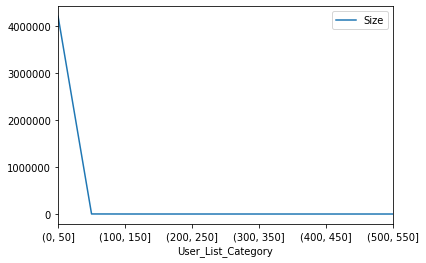

In [5]:
#UserId Column Analysis
user_list['User_List_Category']=pd.cut(x=user_list['Size'], bins=[0,50,100,150,200,250,300,350,400,450,500,550])
a=pd.pivot_table(user_list, index='User_List_Category',values='Size', aggfunc='count')
print(a)
pd.pivot_table(user_list, index='User_List_Category',values='Size', aggfunc='count').plot(kind='line')
plt.show()

In [6]:
most_rated_users = pd.DataFrame(amazon_electronics_data.groupby('UserId')['Ratings'].count())
most_rated_user = most_rated_users.sort_values('Ratings', ascending=False)
print('Top 10 Users who have done Max Purchases:')
most_rated_user.head(10)

Top 10 Users who have done Max Purchases:


,Ratings
UserId,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


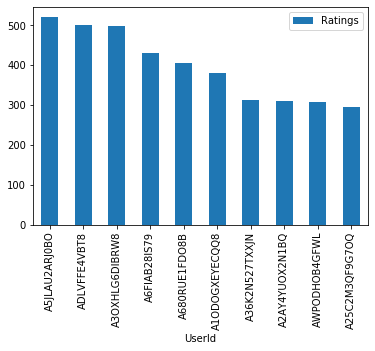

In [13]:
most_rated_user.head(10).plot(kind="bar")
plt.show()

In [5]:
#ProductId Analysis
Product_list=pd.DataFrame(amazon_electronics_data.groupby('ProductId').size(),columns=['Size'])
Product_list=Product_list.reset_index()
print('There are {} Products which is rated only once'.format(Product_list[Product_list['Size'].between(0,1)].count()[0]))
print('There are {} Products which is rated less than 100 times'.format(Product_list[Product_list['Size'].between(2,101)].count()[0]))
print('There are {} Products which is rated more than 100 and less than 200 times'.format(Product_list[Product_list['Size'].between(102,201)].count()[0]))
print('There are {} Products which is rated more than 200 and less than 300 times'.format(Product_list[Product_list['Size'].between(202,301)].count()[0]))
print('There are {} Products which is rated more than 300 and less than 400 times'.format(Product_list[Product_list['Size'].between(302,401)].count()[0]))
print('There are {} Products which is rated more than 400 and less than 500 times'.format(Product_list[Product_list['Size'].between(402,501)].count()[0]))
print('There are {} Products which is rated more than 500 and less than 600 times'.format(Product_list[Product_list['Size'].between(502,601)].count()[0]))
print('There are {} Products which is rated more than 600 and less than 700 times'.format(Product_list[Product_list['Size'].between(602,701)].count()[0]))
print('There are {} Products which is rated more than 700 and less than 800 times'.format(Product_list[Product_list['Size'].between(702,801)].count()[0]))
print('There are {} Products which is rated more than 800 and less than 900 times'.format(Product_list[Product_list['Size'].between(802,901)].count()[0]))
print('There are {} Products which is rated more than 900 and less than 1000 times'.format(Product_list[Product_list['Size'].between(902,1001)].count()[0]))
print('There are {} Products which is rated more than 1000 times'.format(Product_list[Product_list['Size'].between(1001,50000)].count()[0]))

There are 179738 Products which is rated only once
There are 283322 Products which is rated less than 100 times
There are 6889 Products which is rated more than 100 and less than 200 times
There are 2343 Products which is rated more than 200 and less than 300 times
There are 1181 Products which is rated more than 300 and less than 400 times
There are 660 Products which is rated more than 400 and less than 500 times
There are 445 Products which is rated more than 500 and less than 600 times
There are 279 Products which is rated more than 600 and less than 700 times
There are 207 Products which is rated more than 700 and less than 800 times
There are 151 Products which is rated more than 800 and less than 900 times
There are 123 Products which is rated more than 900 and less than 1000 times
There are 665 Products which is rated more than 1000 times


                         Size
Product_list_Category        
(0, 50]                450244
(50, 100]               12681
(100, 150]               4648
(150, 200]               2344
(200, 250]               1449
(250, 300]                910
(300, 350]                698
(350, 400]                492
(400, 450]                364
(450, 500]                302
(500, 550]                249


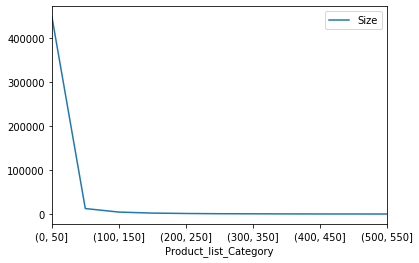

In [8]:
#ProductId Analysis
Product_list['Product_list_Category']=pd.cut(x=Product_list['Size'], bins=[0,50,100,150,200,250,300,350,400,450,500,550])
a=pd.pivot_table(Product_list, index='Product_list_Category',values='Size', aggfunc='count')
print(a)
pd.pivot_table(Product_list, index='Product_list_Category',values='Size', aggfunc='count').plot(kind='line')
plt.show()

In [9]:
popular_products = pd.DataFrame(amazon_electronics_data.groupby('ProductId')['Ratings'].count())
most_popular = popular_products.sort_values('Ratings', ascending=False)
print('Top 10 popular products are:')
most_popular.head(10)

Top 10 popular products are:


,Ratings
ProductId,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226
B003ELYQGG,11617
B003ES5ZUU,10276
B007R5YDYA,9907
B00622AG6S,9823


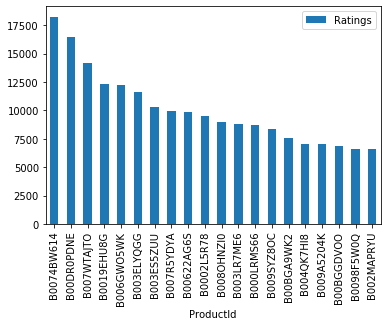

In [10]:
most_popular.head(20).plot(kind="bar")
plt.show()

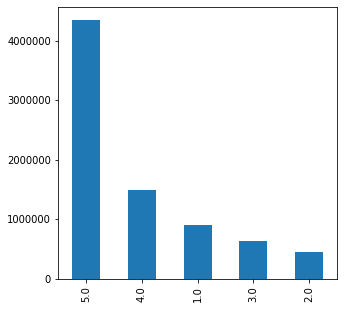

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Ratings, dtype: int64

In [11]:
#Ratings Column Analysis
ax=amazon_electronics_data['Ratings'].value_counts().plot(kind='bar',figsize=(5,5))
plt.show()
amazon_electronics_data['Ratings'].value_counts()

There are 4201428 Users rated less than 100 times and 268 Users rated more than 100 times.
There are 473473 Products which has been rated less than 400 times and 2530 Products which has been rated more than 400 times.
There are 5 different Ratings most of the records in the dataset has the rating 5 only few dataset has the rating 2. 
According to the above dataset there are many records of users who have rated once hence we can consider only the records who have bought more than 50 products for prediction.

# BiVariate Analysis

User who has Bought most of the products is: 3263531    A5JLAU2ARJ0BO
Name: UserId, dtype: object
5.0    275
4.0     83
1.0     67
2.0     51
3.0     44
Name: Ratings, dtype: int64


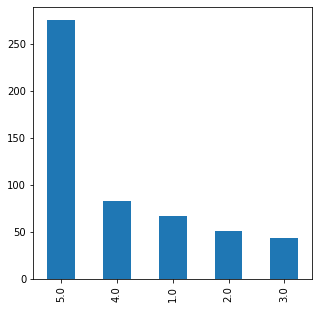

In [19]:
#User vs Rating
print('User who has Bought most of the products is: {}'.format(user_list[user_list['Size'].between(502,601)]['UserId']))
print(amazon_electronics_data[amazon_electronics_data['UserId']=='A5JLAU2ARJ0BO']['Ratings'].value_counts())
amazon_electronics_data[amazon_electronics_data['UserId']=='A5JLAU2ARJ0BO']['Ratings'].value_counts().plot(kind='bar',figsize=(5,5))
plt.show()

Product which was sold most was: 308398    B0074BW614
Name: ProductId, dtype: object
5.0    12765
4.0     3333
3.0     1058
1.0      564
2.0      524
Name: Ratings, dtype: int64


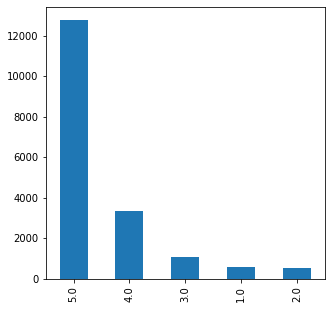

In [20]:
print('Product which was sold most was: {}'.format(Product_list[Product_list['Size']==Product_list[Product_list['Size']>1000].Size.max()]['ProductId']))
print(amazon_electronics_data[amazon_electronics_data['ProductId']=='B0074BW614']['Ratings'].value_counts())
amazon_electronics_data[amazon_electronics_data['ProductId']=='B0074BW614']['Ratings'].value_counts().plot(kind='bar',figsize=(5,5))
plt.show()

User A5JLAU2ARJ0BO has done highest number of purchases and has given 5 ratings for 275 products  , 4 for 83 products , 3 for 44 products, 2 for 51 products and 1 for 67 products.

Product B0074BW614 has been rated maximum times and 12765 Users has rated product as 5, 3333 Users have rated product as 4, 1058 Users have rated product as 3, 524 Users have rated product as 2 and 564 Users have rated product as 1.

Since data is sparse it can be filteres based on Users who have rated more than 50 products and this can be used in creation of User-User Collaborative Recommendation System. 

# Filtering the Data with Users who have rated less than 50 products

In [6]:
#User rated more than 50
amazon_electronics_data_usr=amazon_electronics_data[amazon_electronics_data['UserId'].isin(user_list[user_list['Size'].between(51,520)]['UserId'])]
r,c=amazon_electronics_data_usr.shape#Shape of the Dateset
print('\nHead of new dataset created by Users who rated more than 50 times\n')
print(amazon_electronics_data_usr.head())
print ('\nNumber of Rows in dataset created by Users who rated more than 50 times: {}'.format(r))
print ('Number of Columns in dataset created by Users who rated more than 50 times: {}\n'.format(c))
for i in amazon_electronics_data_usr.columns.tolist():
    print('Unique Value count in the column {} is {}'.format(i,amazon_electronics_data_usr[i].nunique()))


Head of new dataset created by Users who rated more than 50 times

             UserId   ProductId  Ratings
118   AT09WGFUM934H  0594481813      3.0
177  A32HSNCNPRUMTR  0970407998      1.0
178  A17HMM1M7T9PJ1  0970407998      4.0
492  A3CLWR1UUZT6TG  0972683275      5.0
631  A3TAS1AG6FMBQW  0972683275      5.0

Number of Rows in dataset created by Users who rated more than 50 times: 122171
Number of Columns in dataset created by Users who rated more than 50 times: 3

Unique Value count in the column UserId is 1466
Unique Value count in the column ProductId is 47155
Unique Value count in the column Ratings is 5


                    Ratings
User_list_Category         
(50, 75]                908
(75, 100]               278
(100, 125]              127
(125, 150]               55
(150, 175]               27
(175, 200]               20
(200, 225]               17
(225, 250]               11
(250, 300]               14
(300, 325]                3


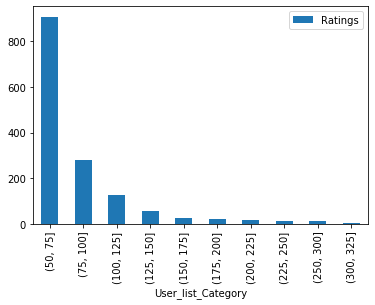

In [13]:
User_list_new=pd.DataFrame(amazon_electronics_data_usr.groupby('UserId')['Ratings'].count())
#User_list_new=User_list_new.reset_index()
User_list_new['User_list_Category']=pd.cut(x=User_list_new['Ratings'], bins=[50,75,100,125,150,175,200,225,250,300,325])
a=pd.pivot_table(User_list_new, index='User_list_Category',values='Ratings', aggfunc='count')
print(a)
pd.pivot_table(User_list_new, index='User_list_Category',values='Ratings', aggfunc='count').plot(kind='bar')
plt.show()

In [14]:
most_rated_users = pd.DataFrame(amazon_electronics_data_usr.groupby('UserId')['Ratings'].count())
most_rated_user = most_rated_users.sort_values('Ratings', ascending=False)
print('Top 10 Users who have done Max Purchases:')
most_rated_user.head(10)

Top 10 Users who have done Max Purchases:


,Ratings
UserId,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


                       Size
Product_list_Category      
(25, 50]                275
(50, 75]                 42
(75, 100]                15
(100, 125]                6
(125, 150]                4
(150, 175]                2
(175, 200]                1
(200, 225]                1


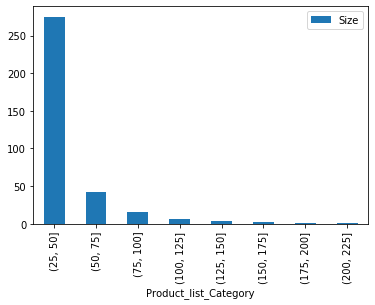

In [7]:
#Product Analysis with User rated more than 50
Product_list_new=pd.DataFrame(amazon_electronics_data_usr.groupby('ProductId').size(),columns=['Size'])
Product_list_new=Product_list_new.reset_index()
Product_list_new['Product_list_Category']=pd.cut(x=Product_list_new['Size'], bins=[25,50,75,100,125,150,175,200,225])
a=pd.pivot_table(Product_list_new, index='Product_list_Category',values='Size', aggfunc='count')
print(a)
pd.pivot_table(Product_list_new, index='Product_list_Category',values='Size', aggfunc='count').plot(kind='bar')
plt.show()

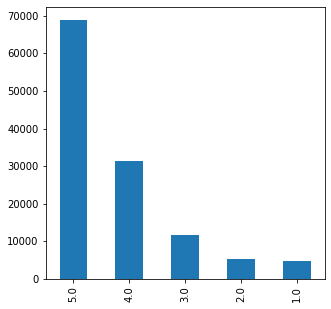

5.0    68872
4.0    31480
3.0    11747
2.0     5175
1.0     4897
Name: Ratings, dtype: int64

In [16]:
#Ratings with User rated more than 50
ax=amazon_electronics_data_usr['Ratings'].value_counts().plot(kind='bar',figsize=(5,5))
plt.show()
amazon_electronics_data_usr['Ratings'].value_counts()

In [8]:
#Ratings with User rated more than 50
user_list_new_rating=pd.DataFrame(amazon_electronics_data_usr.groupby(['UserId','Ratings']).size(),columns=['Count'])
user_list_new_rating=user_list_new_rating.reset_index()
uc=pd.pivot_table(user_list_new_rating,index=['UserId'],columns=['Ratings'],values='Count',aggfunc=max)
for i in [1.0,2.0,3.0,4.0,5.0]:
    print('Total Number of Users who have rated {} is {}'.format(i,uc[i].count()))
print('\n')
Product_list_new_rating=pd.DataFrame(amazon_electronics_data_usr.groupby(['ProductId','Ratings']).size(),columns=['Count'])
Product_list_new_rating=Product_list_new_rating.reset_index()
pc=pd.pivot_table(Product_list_new_rating,index=['ProductId'],columns=['Ratings'],values='Count',aggfunc=max)
for i in [1.0,2.0,3.0,4.0,5.0]:
    print('Total Number of Products who have rated {} is {}'.format(i,pc[i].count()))

Total Number of Users who have rated 1.0 is 1112
Total Number of Users who have rated 2.0 is 1219
Total Number of Users who have rated 3.0 is 1416
Total Number of Users who have rated 4.0 is 1445
Total Number of Users who have rated 5.0 is 1466


Total Number of Products who have rated 1.0 is 4285
Total Number of Products who have rated 2.0 is 4258
Total Number of Products who have rated 3.0 is 8166
Total Number of Products who have rated 4.0 is 17178
Total Number of Products who have rated 5.0 is 32049


Post delete there are 122171 records in the dataset.Among those 1466 unique users and 47155 unique products in the dataset.
There 1186 Users who have bought and rated products more than 50 times and 280 users have rated more than 50 100 times.
There are 46809 Products which has been rated by the Users less than 25 times and 346 products which has been rated more than 25 times.
71034 Products has been rated  5 , 32295 Products rated as 4, 12060 Products rated as 3, 5367 Products rated as 2 and 5115 Products rated as 1

There are 1466 Users who have rated 32049 Products as 5, 1445 Users rated 17178 Products as 4, 1416 Users rated 8166 Products as 3, 1219 Users rated 4258 products as 2 and 1112 Users rated 4285 products as 1.

# Popularity Recommender model (Non Personalized) with user more than 50

In [9]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data_usr, test_data_usr = ts(amazon_electronics_data_usr, test_size = 0.3, random_state=1)
r,c=train_data_usr.shape
print ('Number of Rows in Train dataset is: {}'.format(r))
print ('Number of Columns in Train dataset is: {}'.format(c))
r,c=test_data_usr.shape
print ('\nNumber of Rows in Train dataset is: {}'.format(r))
print ('Number of Columns in Train dataset is: {}\n'.format(c))

train_data_grouped_usr = train_data_usr.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped_usr.rename(columns = {'UserId': 'Score'},inplace=True)
print(train_data_grouped_usr.head(5))
#Sort the products on recommendation score 
train_data_sort_usr = train_data_grouped_usr.sort_values(['Score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort_usr['Rank'] = train_data_sort_usr['Score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations_usr = train_data_sort_usr.head(5) 
popularity_recommendations_usr 

Number of Rows in Train dataset is: 85519
Number of Columns in Train dataset is: 3

Number of Rows in Train dataset is: 36652
Number of Columns in Train dataset is: 3

    ProductId  Score
0  0594481813      1
1  0970407998      1
2  0972683275      2
3  1400501466      2
4  1400501520      1


,ProductId,Score,Rank
30047,B0088CJT4U,143,1.0
19056,B003ES5ZUU,127,2.0
8392,B000N99BBC,120,3.0
29473,B007WTAJTO,112,4.0
29761,B00829TIEK,110,5.0


In [10]:
# Use popularity based recommender model to make predictions
def recommend_usr(user_id):     
    user_recommendations_usr = popularity_recommendations_usr 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations_usr['UserId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations_usr.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations_usr = pd.DataFrame(user_recommendations_usr[cols] ,columns=['UserId','ProductId','Score','Rank'])
          
    return user_recommendations_usr['ProductId']

In [11]:
ul=user_list[user_list['Size'].between(0,1)]['UserId'].head(5)
for i in ul:
    print('\nTop 5 Recommendation for the User with user more than 50 {} are: \n {}'.format(i,recommend_usr(i)))


Top 5 Recommendation for the User with user more than 50 A00000262KYZUE4J55XGL are: 
 30047    B0088CJT4U
19056    B003ES5ZUU
8392     B000N99BBC
29473    B007WTAJTO
29761    B00829TIEK
Name: ProductId, dtype: object

Top 5 Recommendation for the User with user more than 50 A00009182QVLSWIGHLS1B are: 
 30047    B0088CJT4U
19056    B003ES5ZUU
8392     B000N99BBC
29473    B007WTAJTO
29761    B00829TIEK
Name: ProductId, dtype: object

Top 5 Recommendation for the User with user more than 50 A00009661LC9LQPGKJ24G are: 
 30047    B0088CJT4U
19056    B003ES5ZUU
8392     B000N99BBC
29473    B007WTAJTO
29761    B00829TIEK
Name: ProductId, dtype: object

Top 5 Recommendation for the User with user more than 50 A00010809P09NUU6ZP6H are: 
 30047    B0088CJT4U
19056    B003ES5ZUU
8392     B000N99BBC
29473    B007WTAJTO
29761    B00829TIEK
Name: ProductId, dtype: object

Top 5 Recommendation for the User with user more than 50 A00014061C2IZNE0YEILY are: 
 30047    B0088CJT4U
19056    B003ES5ZUU
83

Since the Popularity Recommendor is non Personalized the recommendation is same for all 5 users.The prediction here is based on popularity and it recommondes the most popular products regardless the User has already purchased the product.

# User-User Collaborative Filtering model

Finding the Best User-User Collaborative Model

In [21]:
#Find best user-user
reader = Reader(rating_scale=(1, 5))
surp_data_gs=Dataset.load_from_df(amazon_electronics_data_usr[['UserId','ProductId','Ratings']],reader)
surp_data_gs
m=['rmse','mae','mse']
verbose=False
param_grid ={'k':range(1,50),'name':['pearson_baseline','cosine','MSD','pearson'],
             'user_based': [True],'verbose':[False]}
RGSCV=GridSearchCV(KNNWithMeans , param_grid, measures=['rmse'], cv=5)
RGSCV.fit(surp_data_gs)

print('Best Score with RMSE: {}'.format(RGSCV.best_score['rmse']))
print('Best Parameters for RMSE:{}'.format(RGSCV.best_params['rmse']))

Best Score with RMSE: 1.06091643262699
Best Parameters for RMSE:{'k': 49, 'name': 'pearson_baseline', 'user_based': True, 'verbose': False}


Transforming data to SURPRISE format

In [12]:
reader = Reader(rating_scale=(1, 5))
surp_data_usr=Dataset.load_from_df(amazon_electronics_data_usr[['UserId','ProductId','Ratings']],reader)
trainset_usr,testset_usr =train_test_split(surp_data_usr, test_size=0.3,random_state=1)

Best User User Collaborative Model

In [46]:
algo = KNNWithMeans(k=49, sim_options={'name': 'pearson_baseline', 'user_based': True},verbose=False)
algo.fit(trainset_usr)
test_pred_usr = algo.test(testset_usr)
RMSE_USER_USER=accuracy.rmse(test_pred_usr, verbose=False)
MAE_USER_USER=accuracy.mae(test_pred_usr, verbose=False)
print('Evaluate of User-User Model with pearson_baseline'.format(i))
print('RMSE Score for User-User Model: {}'.format(RMSE_USER_USER))
print('FCP Score for User-User Model: {}'.format(accuracy.fcp(test_pred_usr, verbose=False)))
print('MAE Score for User-User Model: {}'.format(MAE_USER_USER))
print('MSE Score for User-User Model: {}'.format(accuracy.mse(test_pred_usr, verbose=False)))

Evaluate of User-User Model with pearson_baseline
RMSE Score for User-User Model: 1.0501383914689786
FCP Score for User-User Model: 0.44277123859554424
MAE Score for User-User Model: 0.774633806511324
MSE Score for User-User Model: 1.1027906412370538


In [14]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset_usr.ur[trainset_usr.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset_usr.ir[trainset_usr.to_inner_iid(iid)])
    except ValueError: # Item was not part of the trainset
        return 0
    
df = pd.DataFrame(test_pred_usr, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [15]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
36651,A2D1LPEUCTNT8X,B0093AO7TS,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",85,1,0.0
17131,A2M14CFAMF8J7I,B0034CL2ZI,5.0,5.0,"{'actual_k': 20, 'was_impossible': False}",39,72,0.0
17104,A1TQZUSOU22E9M,B00AM4A87O,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",89,8,0.0
17074,AW6FQE5QRF2LM,B004QJ9JLW,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",33,5,0.0
17048,A2VAD79S4A06DD,B00CDIK908,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",41,5,0.0
17003,A1MFVAHTT2BHM0,B008KVUAGU,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",60,6,0.0
16970,AEJAGHLC675A7,B002OGMNT4,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",166,5,0.0
17137,A12R3YGEHW7D8G,B00077KMXG,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",56,1,0.0
16961,A1MEISNED4NP7U,B0054VNHSW,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",45,1,0.0
16924,A3OA4DV4L81N1D,B00009UU2H,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",145,1,0.0


In [16]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1803,A1KKE6VX8VPWZK,B000U62N1S,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",68,5,4.0
34014,A250AXLRBVYKB4,B000I1X6PM,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",151,4,4.0
32830,A9ELHLPXF7JKD,B002MAPRYU,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",48,24,4.0
3276,A34CKIMZ969UW7,B00834SJSK,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",35,70,4.0
31344,A2HRHF83I3NDGT,B002HGFKR8,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",79,13,4.0
20324,A11FX8HL2ANK6T,B0041LYY6K,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",47,6,4.0
9331,A1BJOHHLG0D965,B003VY4M42,1.0,5.0,"{'actual_k': 1, 'was_impossible': False}",52,1,4.0
7843,A1Z7U9K6X3FEOU,B002WP2QGM,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",45,5,4.0
22672,A1GW7V6S6XSXX3,B001FW9QGQ,5.0,1.0,"{'actual_k': 1, 'was_impossible': False}",52,5,4.0
6498,AGVWTYW0ULXHT,B001SJVU6K,5.0,1.0,"{'actual_k': 3, 'was_impossible': False}",167,7,4.0


# Item- Item Based

In [17]:
#Subset of data to perform SVD due to memory issue.
amazon_electronics_data_item=amazon_electronics_data_usr.head(50000)
r,c=amazon_electronics_data_item.shape#Shape of the Dateset
print('\nHead of new dataset created by Users who rated more than 50 times\n')
print(amazon_electronics_data_item.head())
print ('\nNumber of Rows in dataset: {}'.format(r))
print ('Number of Columns in dataset: {}\n'.format(c))
for i in amazon_electronics_data_item.columns.tolist():
    print('Unique Value count in the column {} is {}'.format(i,amazon_electronics_data_item[i].nunique()))


Head of new dataset created by Users who rated more than 50 times

             UserId   ProductId  Ratings
118   AT09WGFUM934H  0594481813      3.0
177  A32HSNCNPRUMTR  0970407998      1.0
178  A17HMM1M7T9PJ1  0970407998      4.0
492  A3CLWR1UUZT6TG  0972683275      5.0
631  A3TAS1AG6FMBQW  0972683275      5.0

Number of Rows in dataset: 50000
Number of Columns in dataset: 3

Unique Value count in the column UserId is 1463
Unique Value count in the column ProductId is 22081
Unique Value count in the column Ratings is 5


In [27]:
#Find Best Item-Item
amazon_electronics_data_item=amazon_electronics_data_usr.head(50000)
reader = Reader(rating_scale=(1, 5))
surp_data_gs=Dataset.load_from_df(amazon_electronics_data_item[['UserId','ProductId','Ratings']],reader)
surp_data_gs
m=['rmse','mae','mse']
verbose=False
param_grid ={'k':range(1,50),'name':['pearson_baseline','cosine','MSD','pearson'],
             'user_based': [False],'verbose':[False]}
RGSCV=GridSearchCV(KNNWithMeans , param_grid, measures=['rmse'], cv=5)
RGSCV.fit(surp_data_gs)

print('Best Score with RMSE for Item-Item: {}'.format(RGSCV.best_score['rmse']))
print('Best Parameters for RMSE Item-Item:{}'.format(RGSCV.best_params['rmse']))

Best Score with RMSE for Item-Item: 1.1285402737326662
Best Parameters for RMSE Item-Item:{'k': 48, 'name': 'pearson_baseline', 'user_based': False, 'verbose': False}


In [47]:
reader = Reader(rating_scale=(1, 5))
surp_data_item=Dataset.load_from_df(amazon_electronics_data_item[['UserId','ProductId','Ratings']],reader)
trainset_item,testset_item =train_test_split(surp_data_item, test_size=0.3,random_state=1)
algo = KNNWithMeans(k=48, sim_options={'name': 'pearson_baseline', 'user_based': False},verbose=False)
algo.fit(trainset_item)
test_pred_item = algo.test(testset_item)
RMSE_ITEM_ITEM=accuracy.rmse(test_pred_item, verbose=False)
MAE_ITEM_ITEM=accuracy.mae(test_pred_item, verbose=False)
print('Evaluate of Item - Item Model with pearson_baseline '.format(i))
print('RMSE Score for Item-Item Model: {}'.format(RMSE_ITEM_ITEM))
print('FCP Score for Item-Item Model: {}'.format(accuracy.fcp(test_pred_item, verbose=False)))
print('MAE Score for Item-Item Model: {}'.format(MAE_ITEM_ITEM))
print('MSE Score for Item-Item Model: {}'.format(accuracy.mse(test_pred_item, verbose=False)))


Evaluate of Item - Item Model with pearson_baseline 
RMSE Score for Item-Item Model: 1.1821732889193572
FCP Score for Item-Item Model: 0.41818704209165347
MAE Score for Item-Item Model: 0.8531086118796806
MSE Score for Item-Item Model: 1.3975336850344102


In [21]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset_item.ur[trainset_item.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset_item.ir[trainset_item.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(test_pred_item, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions_item = df.sort_values(by='err')[:10]
worst_predictions_item = df.sort_values(by='err')[-10:]

In [22]:
best_predictions_item

,uid,iid,rui,est,details,Iu,Ui,err
1163,A1VQHH85U7PX0,B00009R6UU,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",19,1,0.0
512,A4GGT6O0GQNV2,B0002GX0ZE,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,2,0.0
2464,A2SYAQXJGRY3XE,B000144I2Q,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",6,3,0.0
2563,A16SRDVPBXN69C,B00008IOEJ,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",6,1,0.0
1445,A3QDY9I0CNMD2W,B000096B01,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",5,2,0.0
276,A110VKXAVLAYKY,B0002E3WIQ,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",4,1,0.0
2706,A1NMM0RDRF6R84,B0000665V6,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,1,0.0
2865,A1H55L0BLPCWYF,B0002JY712,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,2,0.0
2259,AFXTKAO0CB354,B0000CG4DI,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",12,2,0.0
1370,AZOK5STV85FBJ,B00003006E,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",3,3,0.0


In [23]:
worst_predictions_item

,uid,iid,rui,est,details,Iu,Ui,err
2698,A1F0KPA232MTYC,B000234498,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",4,1,4.0
397,AT6CZDCP4TRGA,B00006J054,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",63,1,4.0
2274,A18GJ9MYYO6GCQ,B00011G5FW,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",2,1,4.0
2159,A3QU3O79AGNWCY,B0002HBOMO,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",5,1,4.0
1053,A6FIAB28IS79,B00006IAAN,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",57,2,4.0
78,AMKNPIDFLRFMP,B0001M4E72,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",5,1,4.0
2891,A2YHXGPCTENZY3,B0000899ZB,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",15,2,4.0
2218,A4WEZJOIZIV4U,B0000BYRIN,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",18,1,4.0
1690,A7EJERNB7IK3Z,B00006DY6M,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",14,1,4.0
2062,ALUNVOQRXOZIA,B00006G2OJ,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",30,1,4.0


# Calculate the density of the rating matrix

In [24]:
#With User rated more than 50
final_ratings_matrix_usr = amazon_electronics_data_usr.pivot(index = 'UserId', columns ='ProductId', values = 'Ratings').fillna(0)
User_ID=final_ratings_matrix_usr.index
Products_Id=final_ratings_matrix_usr.columns
print('Shape of final_ratings_matrix: ', final_ratings_matrix_usr.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix_usr)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix_usr.shape[0] * final_ratings_matrix_usr.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1466, 47155)
given_num_of_ratings =  122171
possible_num_of_ratings =  69129230
density: 0.18%


In [25]:
ratings_mean_count_usr = pd.DataFrame(amazon_electronics_data_usr.groupby('UserId')['Ratings'].mean()) 
ratings_mean_count_usr['rating_counts'] = pd.DataFrame(amazon_electronics_data_usr.groupby('UserId')['Ratings'].count())
ratings_mean_count_usr[ratings_mean_count_usr['rating_counts']==ratings_mean_count_usr['rating_counts'].value_counts().max()]

,Ratings,rating_counts
UserId,,
A15J9K7O10A3M6,4.238095,63
A15U64VGUV6RBF,4.873016,63
A1ASWDAEDTTY5I,4.063492,63
A1BC62X6HZJGZR,4.206349,63
A1CMWB7AWQUQH4,3.841270,63
A1TQBAHI3M4ZBQ,4.809524,63
A200RY2ELZL2Q3,3.793651,63
A23R3EOZ837242,4.079365,63
A27Y4OEC9MD9PA,4.952381,63


There are 36 users who have provided mean ratign between 3 - 4 63 times.

# SVD

In [26]:
# Singular Value Decomposition
U, sigma, Vt = svds(final_ratings_matrix_usr, k = 10)

In [27]:
print('Left singular matrix: \n',U)
print('\nRight singular matrix: \n',Vt)

Left singular matrix: 
 [[-0.00960811  0.0047413  -0.01133839 ... -0.02155433 -0.03413016
  -0.02121137]
 [-0.01051152  0.01828392 -0.00440581 ... -0.01085919  0.02036194
  -0.03868162]
 [-0.00033812 -0.00410202 -0.00366842 ...  0.02975591  0.03284298
  -0.03354981]
 ...
 [-0.0059742   0.08701729  0.02149716 ... -0.01606818 -0.16121324
  -0.06013971]
 [ 0.00165383  0.00360442 -0.00378514 ... -0.00646961  0.00466412
  -0.01349047]
 [ 0.0006001   0.00414323  0.00198817 ... -0.01230474 -0.00229233
  -0.00561352]]

Right singular matrix: 
 [[ 5.50536427e-04  1.07351822e-04  4.97209056e-03 ... -1.92240073e-02
  -8.30897610e-03 -1.60647481e-03]
 [-4.72716412e-04  4.11827301e-04 -3.93664027e-03 ... -2.75388338e-02
  -1.44923234e-03 -1.25127102e-03]
 [ 1.98409718e-04 -4.59856033e-04 -2.18098022e-03 ...  1.02843893e-02
   2.49122232e-03 -4.55604968e-04]
 ...
 [-1.31579189e-03 -4.67220584e-04 -6.77714820e-04 ...  1.33865670e-02
   4.39051485e-03 -1.17218739e-03]
 [-1.70856189e-04 -8.66485907e-05

In [28]:
print('Sigma: \n',sigma)
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Sigma: 
 [ 87.24957032  88.39685887  91.08547353  92.06057958  94.99760999
  98.0847158  100.33308601 106.66806285 119.47759792 181.5107964 ]
Diagonal matrix: 
 [[ 87.24957032   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          88.39685887   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          91.08547353   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          92.06057958   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          94.99760999
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   98.0847158    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.    

In [29]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
predicted_ratings = pd.DataFrame(all_user_predicted_ratings, columns = final_ratings_matrix_usr.columns,index=final_ratings_matrix_usr.index)
predicted_ratings.reset_index(inplace=True)
final_ratings_matrix_usr.reset_index(inplace=True)
predicted_ratings.head()

ProductId,UserId,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,A100UD67AHFODS,0.003574,0.004106,0.004114,0.001519,0.003071,0.005844,0.000504,0.010546,0.002704,...,0.000605,0.044718,0.002920,0.060948,-0.002402,0.006796,0.001514,0.131030,0.059635,0.015090
1,A100WO06OQR8BQ,0.002569,0.005363,0.013273,0.006607,0.001513,0.013490,0.000304,-0.004528,0.001254,...,0.000228,0.029384,0.000089,0.000636,-0.003266,-0.000550,0.004386,-0.039361,-0.006408,0.003812
2,A105S56ODHGJEK,-0.002541,0.002095,0.017831,0.006890,-0.002171,0.005816,0.003470,-0.004045,-0.001645,...,-0.000323,0.009498,-0.002494,-0.016874,0.019722,-0.002480,-0.000172,-0.003130,-0.011089,-0.004675
3,A105TOJ6LTVMBG,0.003963,0.001919,0.007592,0.002871,0.002890,0.003592,0.000112,0.005946,0.002477,...,0.000616,-0.003098,0.003469,-0.003241,-0.000767,0.000159,0.002695,-0.015041,-0.007067,0.003539
4,A10AFVU66A79Y1,0.000112,0.002091,0.008902,0.004068,0.000342,0.006062,0.001018,-0.000888,0.000375,...,0.000007,-0.000698,-0.000316,-0.024802,0.004501,-0.002146,0.001284,-0.048613,-0.016151,-0.003332


In [30]:
# Actual ratings given by the users
print('Actual Ratings by Users: \n')
print(final_ratings_matrix_usr.head(5))

# Average ACTUAL rating for each item
print('\nAverage Actual Ratings by Users: \n')
print(final_ratings_matrix_usr.mean().head(5))

Actual Ratings by Users: 

ProductId          UserId  0594481813  0970407998  0972683275  1400501466  \
0          A100UD67AHFODS         0.0         0.0         0.0         0.0   
1          A100WO06OQR8BQ         0.0         0.0         0.0         0.0   
2          A105S56ODHGJEK         0.0         0.0         0.0         0.0   
3          A105TOJ6LTVMBG         0.0         0.0         0.0         0.0   
4          A10AFVU66A79Y1         0.0         0.0         0.0         0.0   

ProductId  1400501520  1400501776  1400532620  1400532655  140053271X  ...  \
0                 0.0         0.0         0.0         0.0         0.0  ...   
1                 0.0         0.0         0.0         0.0         0.0  ...   
2                 0.0         0.0         0.0         0.0         0.0  ...   
3                 0.0         0.0         0.0         0.0         0.0  ...   
4                 0.0         0.0         0.0         0.0         0.0  ...   

ProductId  B00L5YZCCG  B00L8I6SFY  B00L8Q

In [31]:
# Predicted ratings given by the users
print('Predicted Ratings by Users: \n')
print(predicted_ratings.head(5))

print('\n Average Predicted Ratings by Users: \n')
print(predicted_ratings.mean().head(5))

Predicted Ratings by Users: 

ProductId          UserId  0594481813  0970407998  0972683275  1400501466  \
0          A100UD67AHFODS    0.003574    0.004106    0.004114    0.001519   
1          A100WO06OQR8BQ    0.002569    0.005363    0.013273    0.006607   
2          A105S56ODHGJEK   -0.002541    0.002095    0.017831    0.006890   
3          A105TOJ6LTVMBG    0.003963    0.001919    0.007592    0.002871   
4          A10AFVU66A79Y1    0.000112    0.002091    0.008902    0.004068   

ProductId  1400501520  1400501776  1400532620  1400532655  140053271X  ...  \
0            0.003071    0.005844    0.000504    0.010546    0.002704  ...   
1            0.001513    0.013490    0.000304   -0.004528    0.001254  ...   
2           -0.002171    0.005816    0.003470   -0.004045   -0.001645  ...   
3            0.002890    0.003592    0.000112    0.005946    0.002477  ...   
4            0.000342    0.006062    0.001018   -0.000888    0.000375  ...   

ProductId  B00L5YZCCG  B00L8I6SFY  B00

In [33]:
rmse_df = pd.concat([final_ratings_matrix_usr.mean(), predicted_ratings.mean()], axis=1)
rmse_df.columns = ['Average_Actual_Ratings', 'Average_Predicted_Ratings']
print(rmse_df.shape)
rmse_df['Item_Index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(47155, 2)


,Average_Actual_Ratings,Average_Predicted_Ratings,Item_Index
ProductId,,,
0594481813,0.002046,0.002380,0
0970407998,0.003411,0.002716,1
0972683275,0.010232,0.010664,2
1400501466,0.010232,0.004101,3
1400501520,0.003411,0.001564,4


In [45]:
RMSE_SVD = round((((rmse_df.Average_Actual_Ratings - rmse_df.Average_Predicted_Ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {}'.format(RMSE))

MAE_SVD=round((rmse_df.Average_Actual_Ratings - rmse_df.Average_Predicted_Ratings).mean(),5)
print('\nMAE SVD Model = {}'.format(MAE))


RMSE SVD Model = 0.00342

MAE SVD Model = 0.00114


# Top 5 Recommendation:

In [93]:
# Recommend the items with the highest predicted ratings

def recommend_items(UserId, final_ratings_matrix_usr, predicted_ratings, num_recommendations):
    # Get and sort the user's ratings and sorted_user_ratings
    sorted_user_ratings = final_ratings_matrix_usr[final_ratings_matrix_usr['UserId']==UserId].sort_values(ascending=False,by='UserId').T
     #sorted_user_predictions
    sorted_user_predictions = predicted_ratings[predicted_ratings['UserId']==UserId].sort_values(ascending=False,by='UserId').T
    #Creating the placeholder for User Rating and User Prediction
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended_Items'
    temp.reset_index(inplace=True)
    temp.columns = ['Recommended_Items','User_Ratings', 'User_Predictions']
    temp = temp.loc[temp.User_Ratings == 0]   
    temp = temp.sort_values('User_Predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(UserId))
    print(temp.head(num_recommendations))

In [94]:
#Top 5 recommendation for users
for i in final_ratings_matrix_usr['UserId'].head(5):
    recommend_items(i, final_ratings_matrix_usr, predicted_ratings, 5)


Below are the recommended items for user(user_id = A100UD67AHFODS):

      Recommended_Items User_Ratings User_Predictions
24263        B003ES5ZUU            0          1.07137
37408        B007WTAJTO            0         0.862878
36910        B007OY5V68            0         0.666008
45573        B00G4UQ6U8            0         0.636406
21955        B002V88HFE            0         0.556682

Below are the recommended items for user(user_id = A100WO06OQR8BQ):

      Recommended_Items User_Ratings User_Predictions
10821        B000N99BBC            0          1.45805
37766        B00829TIEK            0          1.26993
28122        B004CLYEDC            0          1.24378
37762        B00829THK0            0          1.06747
37805        B00834SJSK            0         0.797928

Below are the recommended items for user(user_id = A105S56ODHGJEK):

      Recommended_Items User_Ratings User_Predictions
38147        B0088CJT4U            0          1.92631
28122        B004CLYEDC           

# Summary

In [48]:
print('RMSE Scores:')
print('\n USER-USER:{}'.format(RMSE_USER_USER))
print('\n ITEM-ITEM:{}'.format(RMSE_ITEM_ITEM))
print('\n SVD:{}'.format(RMSE_SVD))

print('\nMAE Scores:')
print('\n USER-USER:{}'.format(MAE_USER_USER))
print('\n ITEM-ITEM:{}'.format(MAE_ITEM_ITEM))
print('\n SVD:{}'.format(MAE_SVD))

RMSE Scores:

 USER-USER:1.0501383914689786

 ITEM-ITEM:1.1821732889193572

 SVD:0.00342

MAE Scores:

 USER-USER:0.774633806511324

 ITEM-ITEM:0.8531086118796806

 SVD:0.00114


Popularity based recommendation system works by recommending items viewed/purchased by most people and rated high .
The Popularity-based recommender system is a non-personalised recommender system and these are based on most rated products.
In such case if a user has purchased a product once and rated 5 will be picked over the product which has been rated 4 by multiple Users.
Though the second product is most suitable for the recommendations it will not be considered in Popularity-based recommender system.
Also if the User has already purchased the popular products the same will be suggested for the same Users.


Model-based Collaborative Filtering is a personalised recommender system.Algorithm is entirely based on the user’s past behaviour and not on the context.
Basic assumptions that we consider while building the del-based Collaborative Filtering are:
• Customers who had similar tastes in the past, will have similar tastes in the future
• Users give ratings to Products (implicitly or explicitly).

User - User Based Collaborative filtering
Find out the users who have a similar taste of products as the current user chosen. Similarity is based upon similarity in their purchasing behaviour.
The rating matrix is directly used to find neighbours / make predictions. This will solve the cold start problem. 
The RMSE score for the model is 1.05 and MAE is 1.18 which is very high value and is not a good model.


Item - Item Based Collaborative filtering
Recommend items to the user that are similar to the items the user has bought.Similarity is based upon co-occurence of purchases i.e.
Use the similarity between items (and not users) to make predictions
The RMSE score for the model is 0.77 and MAE is 0.85 which is better than User - User Based Collaborative filtering model.


Matrix Factorization Models:
This model involves identifying the latent features from the input users and items. This creates Rating Matrix to represent Users & Items as vectors in N dimensional Space.The model is predicting different items for different users.
The RMSE score for the SVD(Singular Value Decomposition) is 0.00342 and MAE is 0.00114 which is close to 0. And is excellent model for prediction.